In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nomes.csv.gz')
df.head(100)

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0
...,...,...,...,...,...,...,...,...,...
95,NaN,M,ABENONE,NaN,23.0,23,23,ABENONE,1.0
96,ADENO|ADENOR,M,ABENOR,NaN,111.0,111,2454,ADENOR,1.0
97,ABEROALDO|ADERALDO|ADERILDO|ADEROALDO,M,ABERALDO,NaN,117.0,117,4190,ADERALDO,1.0
98,ADAERCIO|ADERCIO,M,ABERCIO,NaN,57.0,57,696,ADERCIO,1.0


In [ ]:
#Chuyển đổi cột classification từ dữ liệu gốc sang các mã số (encoding) dạng số nguyên
y = df['classification'].astype("category").cat.codes.values
#Chuẩn hóa cột first_name bằng cách chuyển toàn bộ chữ cái trong tên về dạng chữ thường (lowercase).
names = df['first_name'].apply(lambda x: x.lower())

In [ ]:
print(y)

[0 1 1 ... 1 0 1]


In [ ]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


In [ ]:
#Đặt độ dài tối đa của tên là 20 ký tự. Nếu tên ngắn hơn, sẽ được bổ sung bằng ký tự "END". Nếu dài hơn, sẽ bị cắt bớt.
maxlen = 20
'''Define a vocabulary which corresponds to all the unique letters encountered'''
#Tập hợp tất cả các ký tự duy nhất có trong danh sách tên names, cùng với ký tự đặc biệt "END".
#len_vocab: Tổng số ký tự trong từ vựng, dùng để xác định kích thước vector one-hot.
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)

#Mỗi ký tự trong từ vựng được ánh xạ tới một số nguyên dựa trên vị trí của nó.
char_index = dict((c, i) for i, c in enumerate(vocab))

# Tạo một vector one-hot với kích thước bằng từ vựng (len_vocab). Vị trí của ký tự cụ thể sẽ được gán giá trị 1, các vị trí khác là 0.
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # Cắt tên tối đa 20 ký tự
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]  # Mã hóa từng ký tự thành one-hot
        for k in range(0,maxlen - len(str(i))):          # Bổ sung các vector "END" nếu tên ngắn hơn 20 ký tự
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [ ]:
#Chuyển đổi danh sách tên từ names.values (các tên dưới dạng chuỗi) thành ma trận số đã được mã hóa, mỗi tên được biểu diễn bằng một danh sách các vector one-hot.
x = prepare_encod_names(names.values)

In [ ]:
print(x)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Phân chia dữ liệu thành các tập huấn luyện, kiểm tra và val theo tỷ lệ 60%, 20%, và 20%.
# 80% (tập x_train và y_train để tiếp tục chia nhỏ- 60% (tập x_train, y_train cuối),20% (tập x_val, y_val).),
# 20% (x_test và y_test để kiểm tra).
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [ ]:
x_train.shape

(64503, 20, 28)

In [ ]:
y_train.shape

(64503,)

Building the CNN Model

In [ ]:
CNNmodel = keras.Sequential()
CNNmodel.add(Conv1D(32, 2, activation='relu', input_shape=(20,28) )) # 32 convolution filters used each of size 2
CNNmodel.add(Conv1D(64, 3, activation='relu' ))       # 64 convolution filters used each of size 3
CNNmodel.add(MaxPooling1D(pool_size=(1,)))            # choose the best features via pooling
CNNmodel.add(Dropout(0.25))                           # randomly turn neurons on and off to improve convergence
CNNmodel.add(Flatten())                               # flatten we only want a classification output
CNNmodel.add(Dense(150, activation='relu'))           # fully connected to get all relevant data
CNNmodel.add(Dropout(0.1))                            # one more dropout
CNNmodel.add(Dense(1, activation='sigmoid'))          # output

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
CNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=20, batch_size=128) # Getting score metrics
scores = CNNmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5691 - loss: 0.6727 - val_accuracy: 0.7972 - val_loss: 0.4545
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8175 - loss: 0.3987 - val_accuracy: 0.8713 - val_loss: 0.2989
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8691 - loss: 0.2997 - val_accuracy: 0.8860 - val_loss: 0.2687
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8815 - loss: 0.2693 - val_accuracy: 0.8954 - val_loss: 0.2508
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8923 - loss: 0.2542 - val_accuracy: 0.9049 - val_loss: 0.2372
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8985 - loss: 0.2411 - val_accuracy: 0.9095 - val_loss: 0.2276
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9041 - loss: 0.2332 - val_accuracy: 0.9126 - val_loss: 0.2233
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9081 - loss: 0.2244 - val_a

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Precision: 0.92
Recall: 0.91
F1-Score: 0.92
Confusion Matrix:
[[10340   714]
 [  795  8309]]


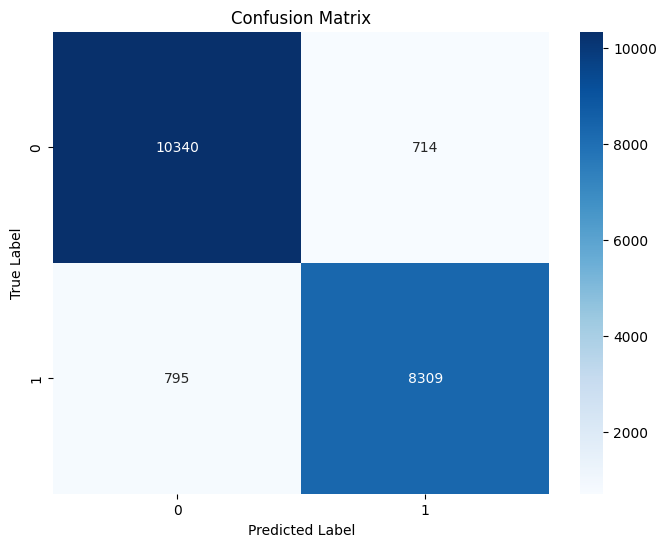

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = CNNmodel.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển xác suất sang nhãn 0 hoặc 1

# Tính các chỉ số Precision, Recall, F1-Score
cnn_precision = precision_score(y_test, y_pred)
cnn_recall = recall_score(y_test, y_pred)
cnn_f1score = f1_score(y_test, y_pred)

print("Precision: %.2f" % cnn_precision)
print("Recall: %.2f" % cnn_recall)
print("F1-Score: %.2f" % cnn_f1score)

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Building RNN model

In [ ]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1)))
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

RNNhistory=RNNmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
RNNscores = RNNmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (RNNscores[1]*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8441 - loss: 0.3399 - val_accuracy: 0.9188 - val_loss: 0.2076
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9170 - loss: 0.2057 - val_accuracy: 0.9244 - val_loss: 0.2031
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9253 - loss: 0.1893 - val_accuracy: 0.9251 - val_loss: 0.1908
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9296 - loss: 0.1793 - val_accuracy: 0.9254 - val_loss: 0.1897
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9292 - loss: 0.1794 - val_accuracy: 0.9273 - val_loss: 0.1884
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9340 - loss: 0.1668 - val_accuracy: 0.9315 - val_loss: 0.1770
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9347 - loss: 0.1650 - val_accuracy: 0.9292 - val_loss: 0.1824
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9387 - loss: 0.1598 - val_acc

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Precision: 0.89
Recall: 0.96
F1-Score: 0.92
Confusion Matrix:
[[10023  1031]
 [  405  8699]]


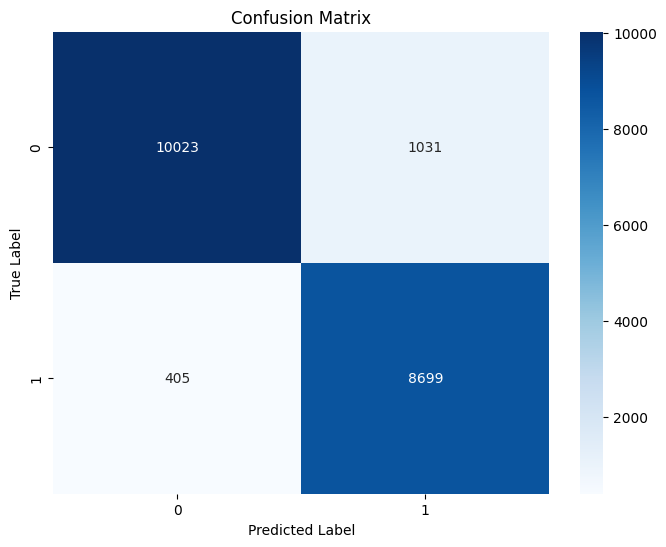

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = RNNmodel.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển xác suất sang nhãn 0 hoặc 1

# Tính các chỉ số Precision, Recall, F1-Score
rnn_precision = precision_score(y_test, y_pred)
rnn_recall = recall_score(y_test, y_pred)
rnn_f1score = f1_score(y_test, y_pred)

print("Precision: %.2f" % rnn_precision)
print("Recall: %.2f" % rnn_recall)
print("F1-Score: %.2f" % rnn_f1score)

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Building GRU model

In [ ]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1)))
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (GRUscores[1]*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8466 - loss: 0.3273 - val_accuracy: 0.9274 - val_loss: 0.1833
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9346 - loss: 0.1703 - val_accuracy: 0.9356 - val_loss: 0.1650
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9435 - loss: 0.1466 - val_accuracy: 0.9402 - val_loss: 0.1558
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9504 - loss: 0.1307 - val_accuracy: 0.9397 - val_loss: 0.1501
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9554 - loss: 0.1193 - val_accuracy: 0.9436 - val_loss: 0.1508
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9565 - loss: 0.1141 - val_accuracy: 0.9470 - val_loss: 0.1390
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9576 - loss: 0.1122 - val_accuracy: 0.9482 - val_loss: 0.1386
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9604 - loss: 0.1040 - 

630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Precision: 0.94
Recall: 0.95
F1-Score: 0.95
Confusion Matrix:
[[10544   510]
 [  477  8627]]


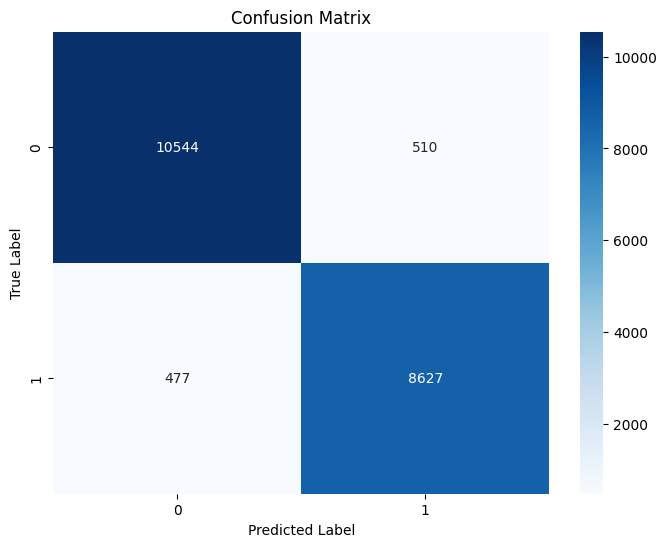

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = GRUmodel.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển xác suất sang nhãn 0 hoặc 1

# Tính các chỉ số Precision, Recall, F1-Score
gru_precision = precision_score(y_test, y_pred)
gru_recall = recall_score(y_test, y_pred)
gru_f1score = f1_score(y_test, y_pred)

print("Precision: %.2f" % gru_precision)
print("Recall: %.2f" % gru_recall)
print("F1-Score: %.2f" % gru_f1score)

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Building MLP model

In [ ]:
DNNmodel = keras.Sequential()
n_inputs = 28
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs)
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1)
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)
output=[]
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))
DNNmodel = keras.Model(inputs=inputs, outputs=output)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

DNNhistory = DNNmodel.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
DNNscores = DNNmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (DNNscores[1]*100))

Epoch 1/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7803 - loss: 0.5267 - val_accuracy: 0.8581 - val_loss: 0.3252
Epoch 2/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8503 - loss: 0.3383 - val_accuracy: 0.8614 - val_loss: 0.3230
Epoch 3/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8540 - loss: 0.3309 - val_accuracy: 0.8586 - val_loss: 0.3248
Epoch 4/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8585 - loss: 0.3241 - val_accuracy: 0.8587 - val_loss: 0.3218
Epoch 5/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8561 - loss: 0.3254 - val_accuracy: 0.8674 - val_loss: 0.3104
Epoch 6/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8621 - loss: 0.3159 - val_accuracy: 0.8675 - val_loss: 0.3132
Epoch 7/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8611 - loss: 0.3183 - val_accuracy: 0.8656 - val_loss: 0.3138
Epoch 8/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8594 - loss: 0

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Precision: 0.87
Recall: 0.84
F1-Score: 0.85
Confusion Matrix:
[[9920 1134]
 [1465 7639]]


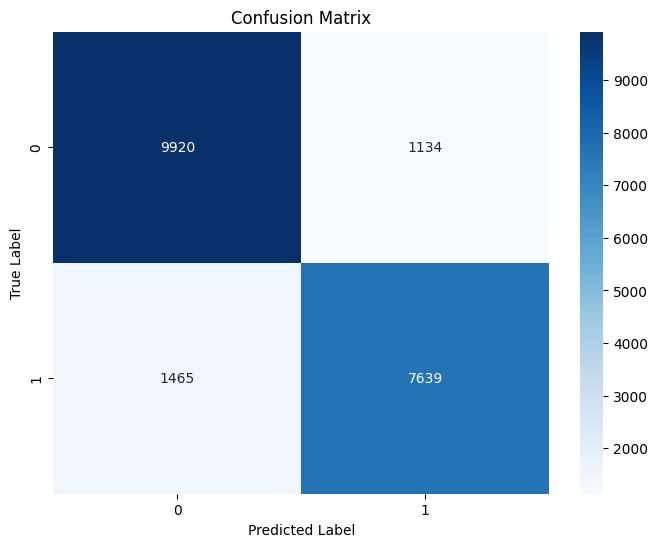

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = DNNmodel.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển xác suất sang nhãn 0 hoặc 1

# Tính các chỉ số Precision, Recall, F1-Score
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_f1score = f1_score(y_test, y_pred)

print("Precision: %.2f" % dnn_precision)
print("Recall: %.2f" % dnn_recall)
print("F1-Score: %.2f" % dnn_f1score)

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Building BiLSTM model

In [ ]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=128, epochs=20, validation_data =(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 93s 171ms/step - accuracy: 0.8287 - loss: 0.6118 - val_accuracy: 0.9246 - val_loss: 0.5661
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 138s 163ms/step - accuracy: 0.9337 - loss: 0.5632 - val_accuracy: 0.9406 - val_loss: 0.5603
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 152s 184ms/step - accuracy: 0.9406 - loss: 0.5591 - val_accuracy: 0.9446 - val_loss: 0.5565
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - accuracy: 0.9495 - loss: 0.5548 - val_accuracy: 0.9478 - val_loss: 0.5550
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 79s 156ms/step - accuracy: 0.9543 - loss: 0.5529 - val_accuracy: 0.9532 - val_loss: 0.5525
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.9614 - loss: 0.5490 - val_accuracy: 0.9541 - val_loss: 0.5522
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.9656 - loss: 0.5473 - val_accuracy: 0.9550 - val_loss: 0.5518
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.9678 - loss

630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Precision: 0.95
Recall: 0.96
F1-Score: 0.95
Confusion Matrix:
[[10623   431]
 [  399  8705]]


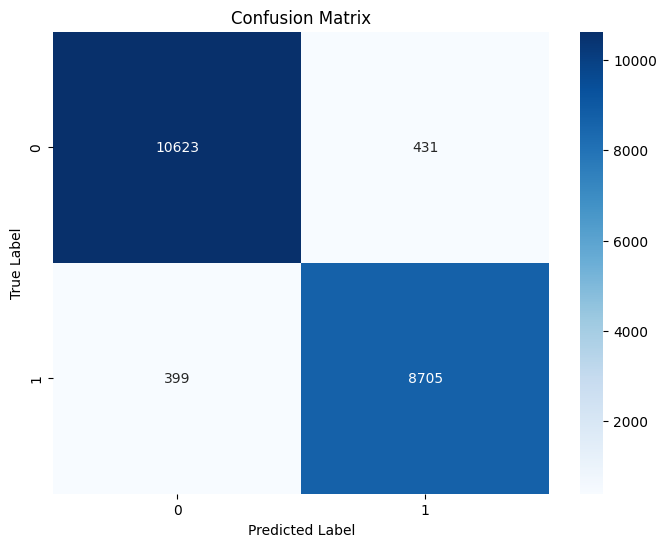

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = LSTMmodel.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển xác suất sang nhãn 0 hoặc 1

# Tính các chỉ số Precision, Recall, F1-Score
lstm_precision = precision_score(y_test, y_pred)
lstm_recall = recall_score(y_test, y_pred)
lstm_f1score = f1_score(y_test, y_pred)

print("Precision: %.2f" % lstm_precision)
print("Recall: %.2f" % lstm_recall)
print("F1-Score: %.2f" % lstm_f1score)

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Sự thay đổi độ chính xác qua từng epoch của mỗi mô hình:

<Figure size 640x480 with 0 Axes>

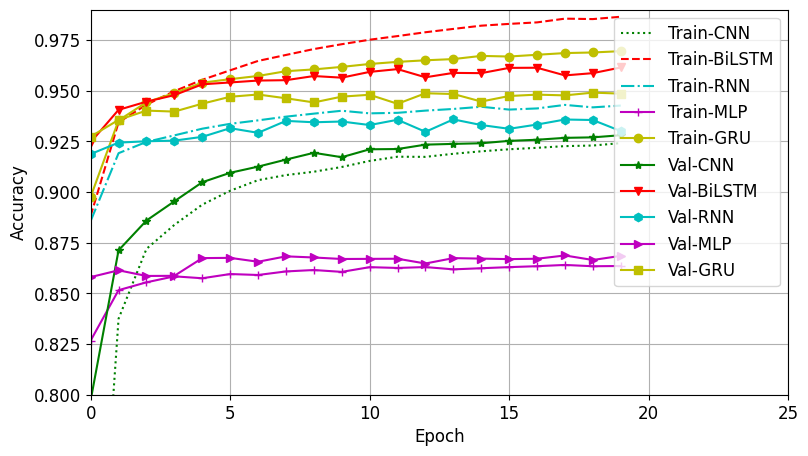

In [ ]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')


Sự biến thiên của hàm loss qua mỗi epoch của từng model.

(0.0, 32.0)

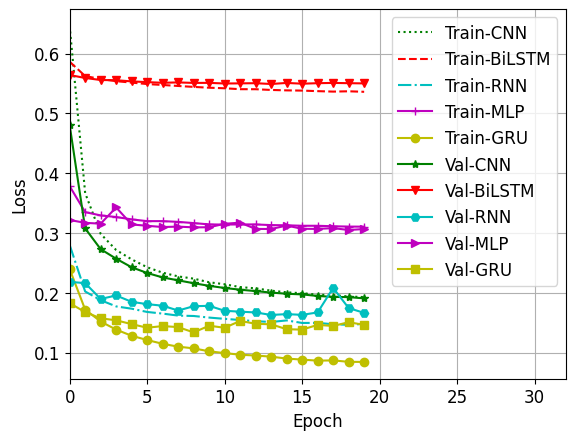

In [ ]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)

In [ ]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


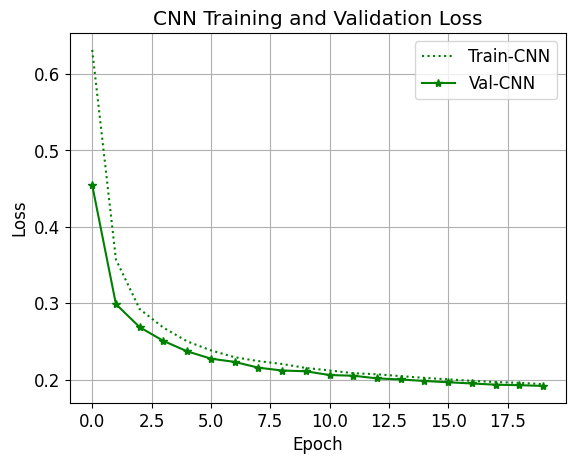

In [ ]:
plt.figure()
plt.plot(CNNhistory.history['loss'][:21], 'g:', label='Train-CNN')
plt.plot(CNNhistory.history['val_loss'][:21], 'g-*', label='Val-CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('CNN Training and Validation Loss')
plt.show()


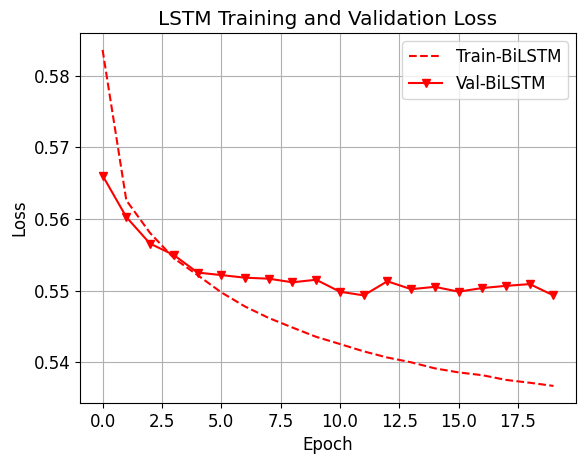

In [ ]:
plt.figure()
plt.plot(LSTMhistory.history['loss'], 'r--', label='Train-BiLSTM')
plt.plot(LSTMhistory.history['val_loss'], 'r-v', label='Val-BiLSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('LSTM Training and Validation Loss')
plt.show()


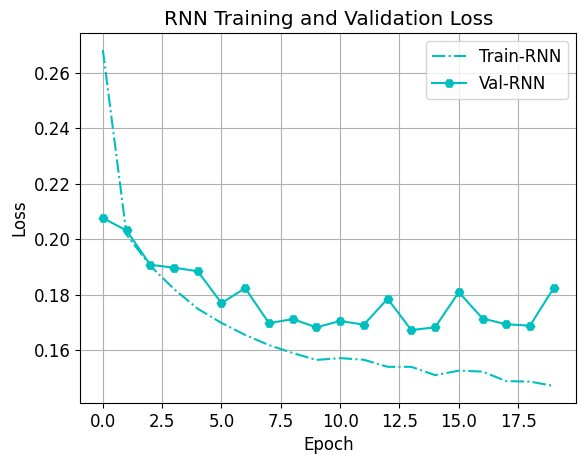

In [ ]:
plt.figure()
plt.plot(RNNhistory.history['loss'], 'c-.', label='Train-RNN')
plt.plot(RNNhistory.history['val_loss'], 'c-H', label='Val-RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('RNN Training and Validation Loss')
plt.show()


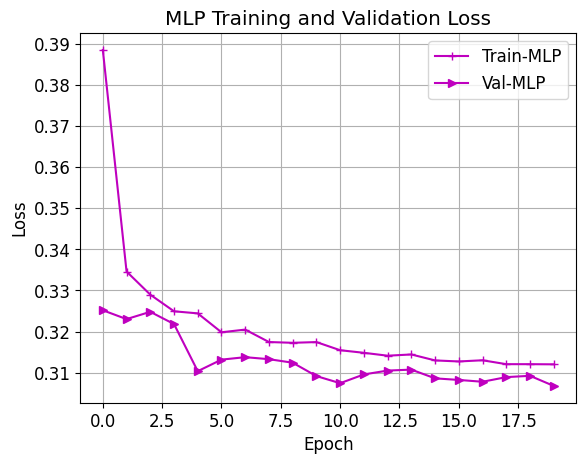

In [ ]:
plt.figure()
plt.plot(DNNhistory.history['loss'], 'm-+', label='Train-MLP')
plt.plot(DNNhistory.history['val_loss'], 'm->', label='Val-MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('MLP Training and Validation Loss')
plt.show()


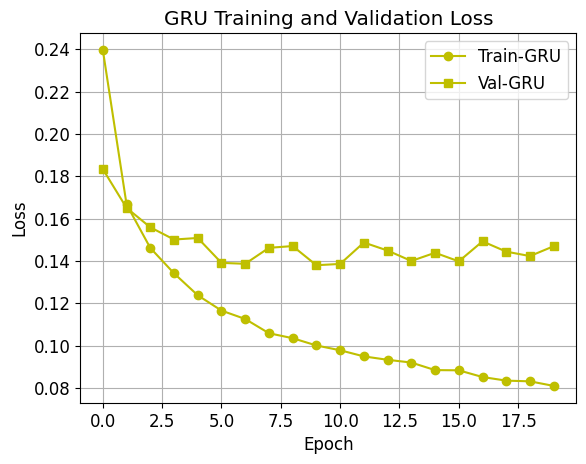

In [ ]:
plt.figure()
plt.plot(GRUhistory.history['loss'], 'y-o', label='Train-GRU')
plt.plot(GRUhistory.history['val_loss'], 'y-s', label='Val-GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('GRU Training and Validation Loss')
plt.show()


In [ ]:
testename = np.array(prepare_encod_names(["cibely"]))  # Đầu vào
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
F


<ipython-input-27-a7deb50ceb7b>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(resu)==1:
